Questions to consider later:
- Do images needs to be normalized? 
- Do we need to do any special pre-processing to the text data? 

In [1]:
# pip install pillow 
import json
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Data pre-processing

In [2]:
path_images = Path("data/images")
ids = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids), ids[:3] 

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [4]:
# Load train annotations data only, as specified in the task

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)['train']

ids_annot = [item['id'] for item in data]
assert all(item in ids for item in ids_annot) 
del ids

len(data), data[0]    

(2069,
 {'id': 'CXR2384_IM-0942',
  'report': {'bone': 'Degenerative changes are present in the spine.',
   'heart': 'Heart size and pulmonary vascularity appear within normal limits.',
   'lung': 'Lungs are free of focal airspace disease. No pneumothorax or pleural effusion is seen.',
   'mediastinal': '',
   'others': 'A large hiatal hernia is noted.'},
  'split': 'train'})

In [6]:
# Vast majority of images consists of 2 images. Let's assume we select only the first 2. Ideally, need to generalize this later. 

def count_images_in_folder(folder_path):
    
    count = sum(1 for file in folder_path.iterdir() if file.suffix.lower() in {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"} )
    return count

images_count = {folder_id: count_images_in_folder(path_images / folder_id) for folder_id in ids_annot}

Counter(images_count.values())

Counter({2: 1966, 3: 99, 4: 4})

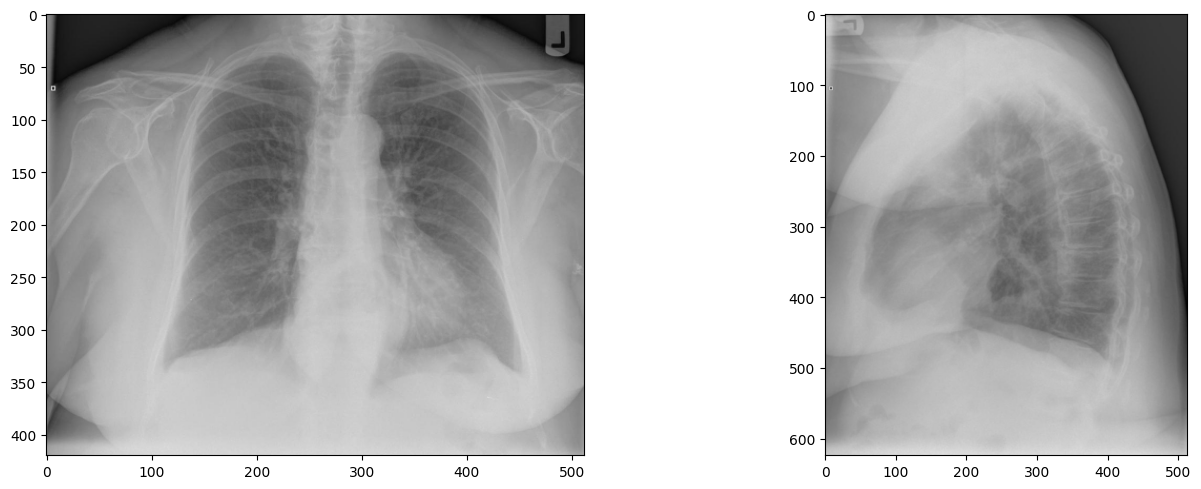

In [22]:
# Plot manually selected id. Images are various sizes. 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, image_filename in zip(axes, ["0.png", "1.png"]):
    path_image = path_images / ids_annot[0] / image_filename
    img = Image.open(path_image)
    ax.imshow(img)

plt.tight_layout()

In [ ]:
sizes = []

for folder_id in ids_annot:
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")

        sizes.append({'id': folder_id,
                      'img0_w': img0.size[0], 'img0_h': img0.size[1],
                      'img1_w': img1.size[0], 'img1_h': img1.size[1] })
    except FileNotFoundError as e:
        print(f"File not found: {e}")

sizes = pd.DataFrame(sizes).set_index('id')  
sizes

,img0_w,img0_h,img1_w,img1_h
id,,,,
CXR2384_IM-0942,512,420,512,624
CXR2926_IM-1328,512,512,512,562
CXR1451_IM-0291,512,420,512,624
CXR2887_IM-1289,512,512,512,530
CXR1647_IM-0424,512,624,512,420
...,...,...,...,...
CXR1600_IM-0390,512,420,512,624
CXR2465_IM-0997,512,420,512,624
CXR1595_IM-0386,512,624,512,420


In [41]:
# Widths of images 0 and 1 are the same 512. Can concatinate based on the same widths

sizes['img0_w'].value_counts(dropna=False), sizes['img1_w'].value_counts(dropna=False) 
# sizes['img0_h'].value_counts(dropna=False), sizes['img1_h'].value_counts(dropna=False)

(img0_w
 512    2069
 Name: count, dtype: int64,
 img1_w
 512    2069
 Name: count, dtype: int64)

In [46]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image


for folder_id in ids_annot[:1]:
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")


In [ ]:
# <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x302>}

In [ ]:
instruction = """
You are a specialist Radiologist who specialize in diagnosing and writing reports based on X-ray medical images. 
Write a radiology report accurately by looking at the image provided. 
Images can be in mixed format either Frontal and Lateral, or Lateral and Frontal and consists of concatinated two images.   
"""

# sample["image"], sample["description"], dataset


def build_conversations(sample):
    conversation = [
        {   "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["description"]}],
        },
    ]
    return {"messages": conversation}



converted_dataset = [build_conversations(sample) for sample in dataset]

# Modelling

In [ ]:
# pip install unsloth

from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/Llama-3.2-11B-Vision-Instruct",
        load_in_4bit = True,
        use_gradient_checkpointing = "unsloth") 

In [ ]:
model = FastVisionModel.get_peft_model(
            model,
            finetune_vision_layers    = True, 
            finetune_language_layers  = True, 
            finetune_attention_modules= True,
            finetune_mlp_modules      = True,
            r = 16,           
            lora_alpha = 16,
            lora_dropout = 0,
            bias = "none",
            random_state = 3443,
            use_rslora = False,
            loftq_config = None )

